### Imports and set up

In [33]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import pickle
import random

#torch imports 
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
from torcheeg.io.eeg_signal import EEGSignalIO
from torcheeg.models import DGCNN
from sklearn.metrics import accuracy_score
from torcheeg.models.gnn.dgcnn import GraphConvolution
# helper sctipts 
import utils.graph_utils as gu
import utils.data_utils as du
import utils.model_utils as mu 
import utils.visual_utils as vu
from utils.model_utils import TrainNN
from utils.cka import CKACalculator

# tracking 
import wandb

#visualizations
import mne 

## Path constants
path="artifacts"
modelname="dgcnn_mod"
data_path = "../data/"
preprocessed_data_path = f"{path}/preprocessed_data.npy"
has_val_set = False
#seed = 42
saved_path = "./models"

## Establish connection to datafile
IO = EEGSignalIO(io_path=str(data_path), io_mode='lmdb')
bands = {"delta": [1, 4],"theta": [4, 8],"alpha": [8, 14],"beta": [14, 31],"gamma": [31, 49]}

## Read metadata dataframeimports
metadata = pd.read_csv(data_path + 'sample_metadata.tsv', sep='\t')



In [34]:
def read_saved_models(saved_path):    
    main_folder_files = []
    for folder in os.listdir(saved_path):
        if "gpuerror" not in folder:
            file_names = os.listdir(saved_path + "/" + folder)
            folder_seed = int(folder.split("_")[-1])
            main_folder_files.append([folder, file_names, folder_seed])

    model_objects = dict()
    for folder_name, folder_files, seed in main_folder_files:
        #print(f"for seed = {seed}")
        model_objects[seed] = dict()
        for file_name in folder_files:

            if file_name[:5] == "model":
                #print(f"file_name: {file_name} - MODEL file")
                chans = int(file_name.split("_")[3][4:])
                full_model_path = saved_path + "/" + folder_name + "/" + file_name
                
                curr_mod = DGCNN(in_channels=5, num_electrodes=22, 
                              hid_channels=chans, num_layers=2, num_classes=5)
                
                model_weights = torch.load(full_model_path)
                curr_mod.load_state_dict(model_weights)
                model_objects[seed][chans] = curr_mod
                
    return model_objects

In [35]:
model_objects = read_saved_models(saved_path)

In [63]:
print(len(model_objects[66052]))

6


In [36]:
# Verifying connection to data
idxs = np.arange(len(metadata))

# Read features and labels as torch tensors
X = torch.FloatTensor(np.array([IO.read_eeg(str(i)) for i in idxs]))
y = torch.tensor(metadata["value"].values, dtype=torch.long)

In [37]:
X_bde = du.band_preprocess(X, preprocessed_data_path)     

### Split data into train, validation and test sets

In [38]:
if has_val_set:
    X_train, y_train, X_val, y_val, X_test, y_test = du.split_data(X_bde, y, has_val_set=has_val_set, seed=seed)
    assert (X_train.shape[0]+X_val.shape[0]+X_test.shape[0])==X.shape[0], "Data samples lost in preprossesing"
    assert (y_train.shape[0]+y_val.shape[0]+y_test.shape[0])==X.shape[0], "Data samples lost in preprossesing"
    
    nsamples_val, nchannels_val, bands = X_val.shape
    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
    
else:
    X_train, y_train, X_test, y_test = du.split_data(X_bde, y, has_val_set=has_val_set, seed=seed)
    assert (X_train.shape[0]+X_test.shape[0])==X.shape[0], "Data samples lost in preprossesing"
    assert (y_train.shape[0]+y_test.shape[0])==X.shape[0], "Data samples lost in preprossesing"

assert X_train.shape[1]==X.shape[1],"Preprossed data lost channels"
assert X_train.shape[2]==len(bands),"Preprossed data does have incorrect amount of bands"

nsamples_train, nchannels_train, bands = X_train.shape
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

### Training & model hyperparameters

## Train model
### Train 4 models and calculate CKA matrices for pairs of models
## Functions to get activations of a layer type and calculated adjacency matrix

In [39]:
wandb.login()
# DICTIONARY PARAMETERS
def train_models(model,modeltrainer,hid_chans,seed_list,num_models=1,new=False,prints=False,path=path,modelname=modelname):
    """
    Training a model with random initialisation but consitent parameters. 
    
    Hyper parameters should be set outside of this function 
    
    path and model_names are both needed parameters that need to be defined outside of this function. 
    
    Path is to where your artifacts are located and model_name is what the model is called 
    
    ...
    
    Parameters
    -----------
    model : nn.modules
        The model being trained
    modeltrainer : training class
        a class for training the model provided should return a trained model
    num_models : int 
        Default 1, how many models it trains
    new : bool
        Weather it should attempt to use saved models
    """
    mods = []
    for i in range(num_models):
        
        tmp_mod = model(in_channels=num_chans, num_electrodes=num_electrodes, 
                              hid_channels=hid_chans, num_layers=num_layers, num_classes=num_outputs)
        model_path=f"{path}/{modelname}_chan{hid_chans}_{i}.pth"
        print(f"Model {i+1}")
        if new or not os.path.exists(model_path):    
            if not os.path.exists(model_path) and not new:
                print(f"Could not resolve path: {model_path}")
                new_models=True
            trainer = modeltrainer()
            
            if has_val_set:
                mods.append(trainer.train_model(tmp_mod, train_loader, learning_rate=lr,path=path,name=f"{modelname}_chan{hid_chans}",
                            has_val_set=has_val_set,val_loader=val_loader,w_decay=w_decay,epochs=epochs, 
                            prints=prints, modrun=i, seed=seed_list[i]))
            else:
                mods.append(trainer.train_model(tmp_mod, train_loader, learning_rate=lr,path=path,name=f"{modelname}_chan{hid_chans}",
                                                has_val_set=has_val_set,val_loader=None,w_decay=w_decay,epochs=epochs, 
                                                prints=prints, modrun=i, seed=seed_list[i]))   
        else: 
            tmp_mod.load_state_dict(torch.load(model_path))
            tmp_mod.eval()
            mods.append([tmp_mod,[]])
    return mods

In [40]:
# Model parameters
num_chans = 5
num_electrodes = 22
num_outputs = y.max().item() + 1
num_layers = 2
hid_chans = 16

# Training parameters
lr = 1e-4
epochs = 40
w_decay = 1e-3

seed_list = [42, 30, 66, 89]

#Models 
modruns = 4
plot=True
new_models=False
#mods = train_models(DGCNN, TrainNN,hid_chans,seed_list, num_models=modruns, prints=plot, new=new_models)

In [41]:
# while true loop
# generate random seed
# train one model for each parameter set with this seed
# save those models and their metrics to files
# new folder for each run of multi_param

def lst_to_dict(lst):
    return dict([(x, []) for x in lst])
def internal_dict(lst):
    models_dict     = lst_to_dict(lst)  #Dict with all models
    bary_dict       = lst_to_dict(lst)  #Graph metric dict n for barycenter
    sim_dict        = lst_to_dict(lst)  #Graph metric dict n for simrank
    edit_dists      = lst_to_dict(lst)  #Graph metric dict n for GED between similar param models
    return models_dict,bary_dict,sim_dict,edit_dists

def run_models_hpc(param_list, n_runs):
    
    run_idx = 1
    
    while run_idx < n_runs:
        random_seed = random.randint(0, 999999)
        random.seed(random_seed)
        torch.manual_seed(random_seed)
        np.random.seed(random_seed)

        print(run_idx)
        path_name = f"run_{run_idx}_seed_{random_seed}"
        os.makedirs(path_name)
        print(run_idx)
        
        models_dict, bary_dict, sim_dict, _ = internal_dict(param_list)
        
        for n_chans in param_list:
            model_name = f"model_chans_{n_chans}_seed_{random_seed}"
            curr_model = [x[0] for x in train_models(DGCNN, TrainNN, n_chans, seed_list, num_models = 1,
                                                     prints=False, new=True, path=path_name, modelname=model_name)]
            models_dict[n_chans].extend(curr_model)
        
        for n_chans in param_list:
            models = models_dict[n_chans]
            bary, sim, _, _ = gu.get_graph_metrics(models, prints=False)
            bary_dict[n_chans].extend(bary)
            sim_dict[n_chans].extend(sim)
        
        file_suffix = f"_seed_{random_seed}"

        with open(f'{path_name}/barycenters{file_suffix}.pkl', 'wb') as fp:
            pickle.dump(bary_dict, fp)
            
        with open(f'{path_name}/simrank{file_suffix}.pkl', 'wb') as fp:
            pickle.dump(sim_dict, fp)
        
        run_idx += 1

In [ ]:
def multi_parameter_mod(param_list, seed_list, n_models):
    # TO DO: take into account seeds. Right now the seed_list doesn't do anything
    # all combinations of model indexes between two parameter sets
    # ex all model combinations between models with 8 hidden neurons and models with 16 hidden neurons
    
    
    combs_external =[
        (i, j)
        for i in range(n_models)
        for j in range(n_models, 2 * n_models)
        ]
    #combs_external = list(itertools.product([x for x in range(n_models)], [x+n_models for x in range(n_models)]))
    # all combinations of parameter values, in this case number of hidden neurons
    param_combs = [
        (param_list[i], param_list[j]) 
        for i in range(0,   len(param_list)) 
        for j in range(i+1, len(param_list))]
    
    models_dict, bary_dict, sim_dict, edit_dists_internal = internal_dict(param_list)
    edit_dists_external = lst_to_dict(param_combs)   #Graph metric dict n for GED between different param models
    
    # train n_models models with each number of hidden neurons specified in the param_list
    for n_chans in param_list:
        curr_model = [x[0] for x in train_models(DGCNN, TrainNN, n_chans, seed_list, num_models = n_models,
                                                 prints=plot, new=False)]
        models_dict[n_chans].extend(curr_model)
    
    # calculate all metrics for models with the same number of hidden neurons
    for n_chans in param_list:
        models = models_dict[n_chans]
        bary, sim, _, ed = gu.get_graph_metrics(models, prints=False)
        bary_dict[n_chans].extend(bary)
        sim_dict[n_chans].extend(sim)
        edit_dists_internal[n_chans].extend(ed)
    
    # calculate edit distance between models with different number of hidden neurons
    for param_comb in param_combs:
        for ext_comb in combs_external:
            model1_idx = ext_comb[0]; model2_idx = ext_comb[1]
            model1 = models_dict[param_comb[0]][model1_idx]
            model2 = models_dict[param_comb[1]][model2_idx-n_models]
            G1 = gu.make_graph(mu.get_adj_mat(model1))
            G2 = gu.make_graph(mu.get_adj_mat(model2))
            ed_external = next(nx.optimize_graph_edit_distance(G1, G2))
            edit_dists_external[param_comb].append(ed_external)

    return models_dict, bary_dict, sim_dict, edit_dists_internal, edit_dists_external

In [43]:
param_list = [8, 16, 24]
seed_list = [42, 30, 66, 89]

n_models = 4

models, barycenters, sims, edit_dists_internal, edit_dists_external = multi_parameter_mod(param_list, seed_list, n_models)

Model 1
Model 2
Model 3
Model 4
Model 1
Model 2
Model 3
Model 4
Model 1
Model 2
Model 3
Model 4


In [44]:
def simrank_to_matrix(sim):
    
    n = len(sim)
    mat = np.zeros((n,n))
    
    for i in range(n):
        for j in range(n):
            
            mat[i, j] = sim[i][j]
    return mat

In [45]:
def plot_simrank(sims, n_nodes=22, figsize=(5,5)):
    
    for k in sims.keys():
        curr_sims = sims[k]
        for i in range(len(curr_sims)):
            curr_mat = simrank_to_matrix(curr_sims[i])
            vu.plot_matrix(f"Simrank for k = {k} model idx {i}", curr_mat, list(range(n_nodes)), list(range(n_nodes)), 
                           cbarlabel="", cellvalues=False, figsize=figsize)

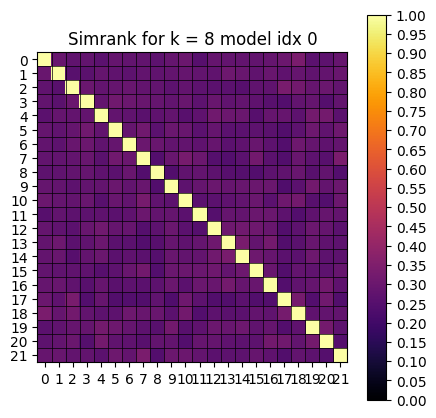

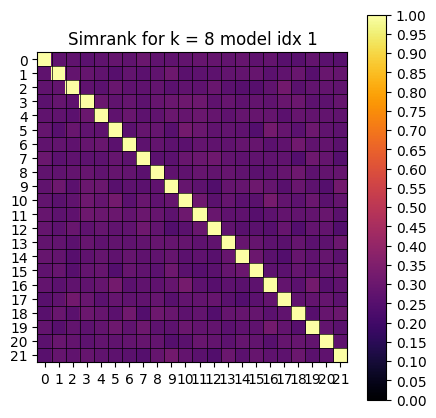

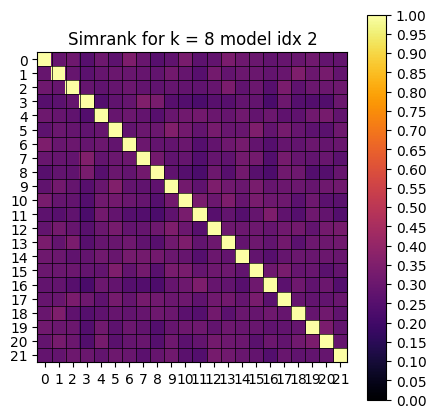

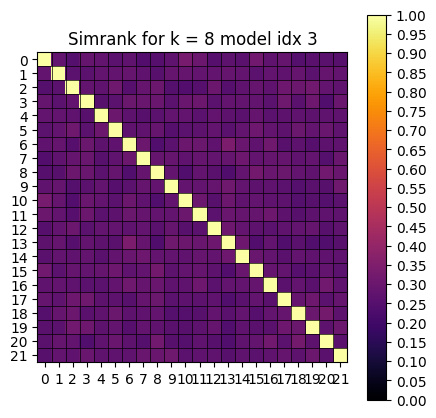

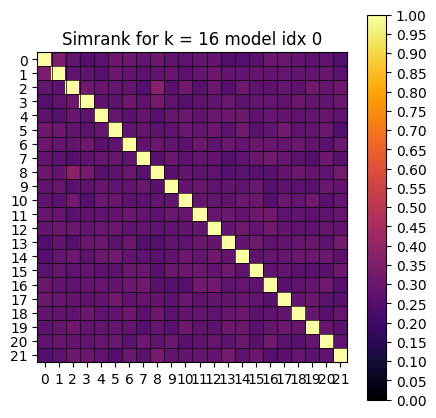

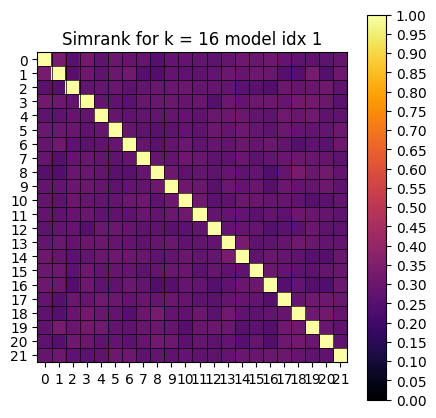

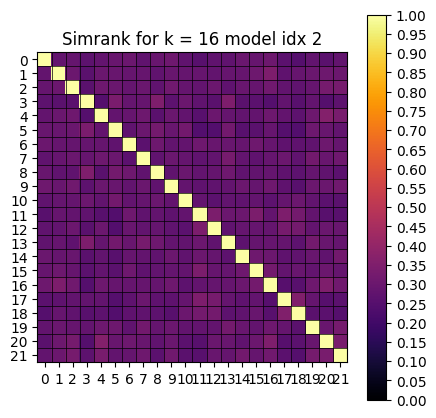

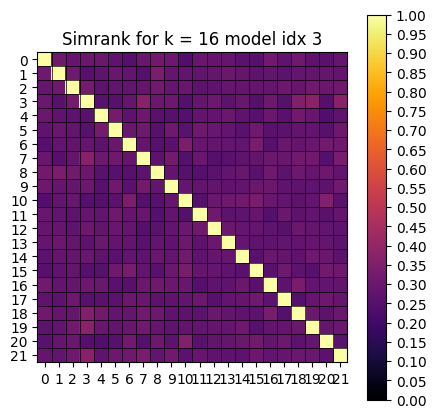

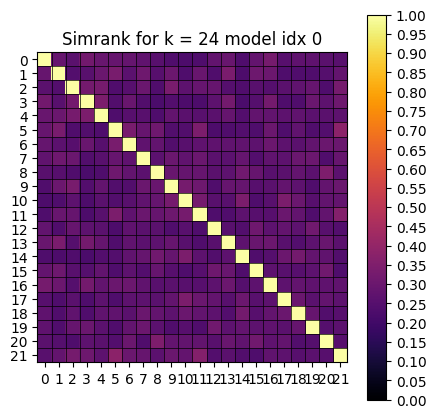

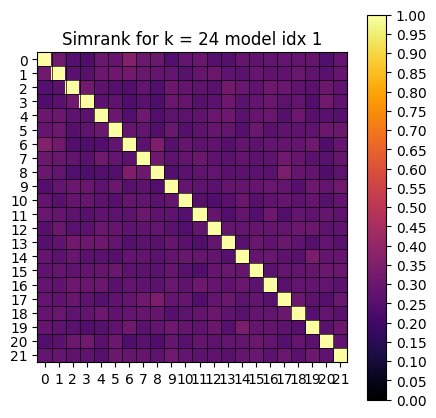

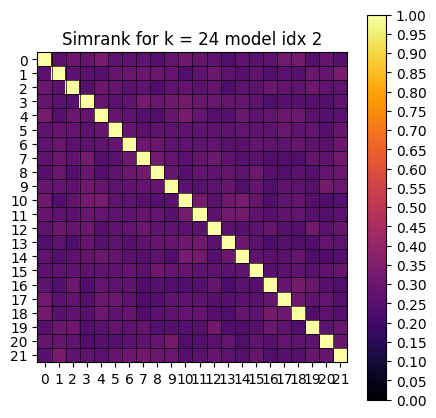

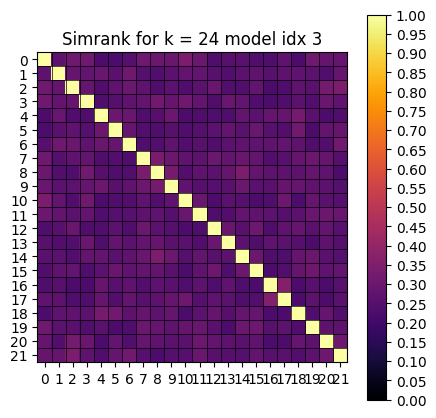

In [46]:
plot_simrank(sims, n_nodes=22, figsize=(5,5))

In [47]:
for k in edit_dists_internal.keys():
    
    curr_list = edit_dists_internal[k]
    print(f"{k}: {sum(curr_list) / len(curr_list)}")

8: 104.16666666666667
16: 103.33333333333333
24: 96.66666666666667


In [48]:
for k in edit_dists_external.keys():
    
    curr_list = edit_dists_external[k]
    print(f"{k}: {sum(curr_list) / len(curr_list)}")

(8, 16): 102.0
(8, 24): 100.875
(16, 24): 101.5


In [49]:
node_labels = pd.read_csv("node_names.tsv", sep="\t")
node_labels = list(node_labels['name'])

for k in barycenters.keys():
    
    print(f"For n_neurons = {k}")
    print([[node_labels[x] for x in s] for s in barycenters[k]])

For n_neurons = 8
[['C5'], ['C1', 'CP3'], ['CP1'], ['FC3']]
For n_neurons = 16
[['C6'], ['C5'], ['Cz', 'CP1'], ['CP3']]
For n_neurons = 24
[['C5', 'C1', 'CP2'], ['POz'], ['FC4'], ['FC3']]


Model 1 test
Acc train: 0.5022908126356402
Acc test: 0.4416586306653809
F1 train: 0.4990024442235326
F1 test: 0.43637043779892104


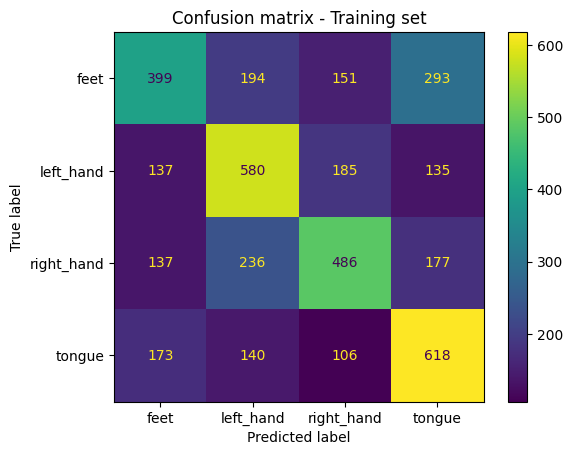

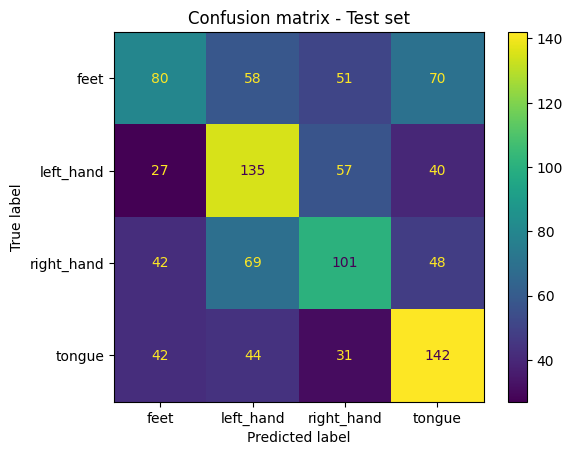

Model 2 test
Acc train: 0.4928864239209067
Acc test: 0.45515911282545807
F1 train: 0.48972729460579556
F1 test: 0.4518075680444766


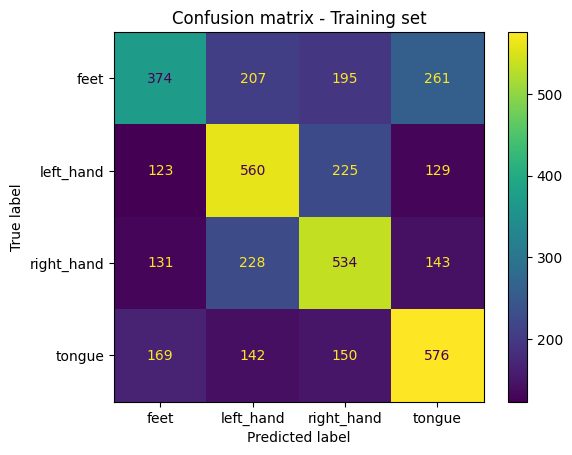

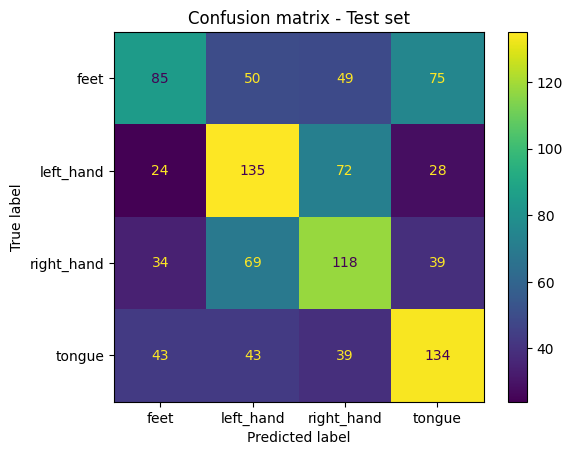

Model 3 test
Acc train: 0.501808536291295
Acc test: 0.4339440694310511
F1 train: 0.4992706600976594
F1 test: 0.43102298644213005


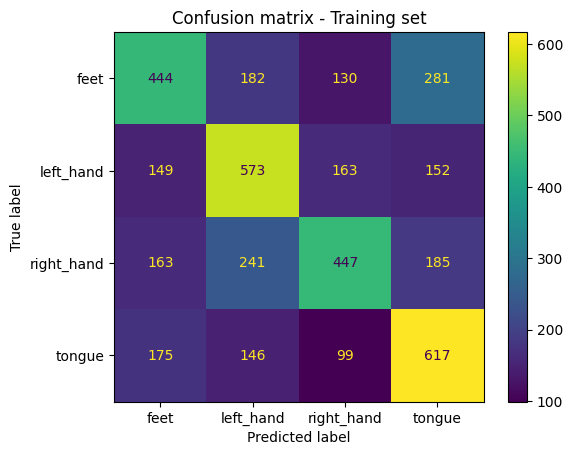

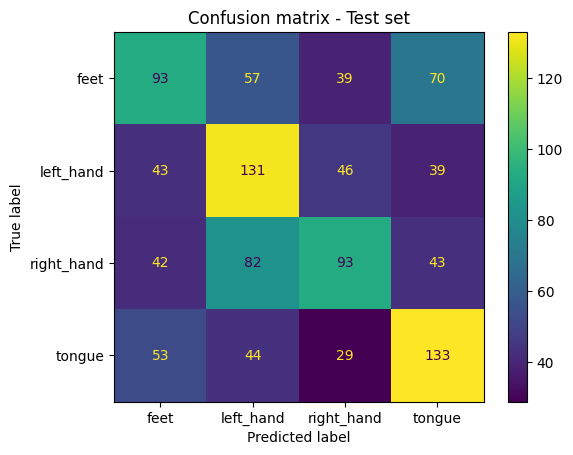

Model 4 test
Acc train: 0.5097660959729925
Acc test: 0.43105110896817744
F1 train: 0.5081712623509012
F1 test: 0.4287606939852392


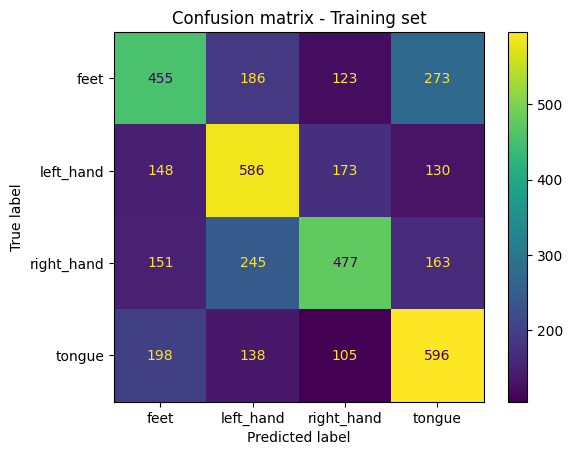

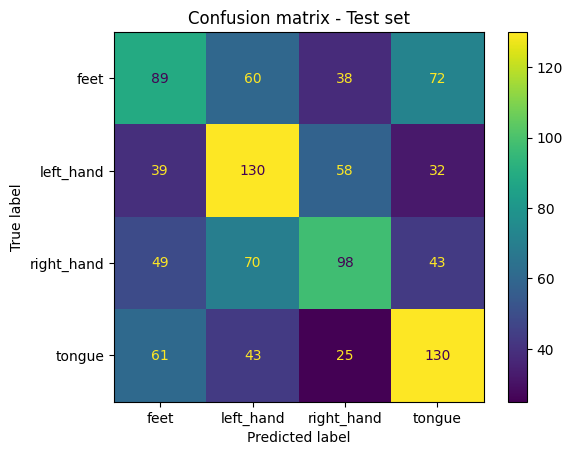

In [50]:
for i in range(modruns):
    print(f"Model {i+1} test")
    test_model = mods[i][0].to("cpu").eval()
    mu.model_metrics(test_model, X_train, y_train, X_test, y_test, None, None,plots=plot)

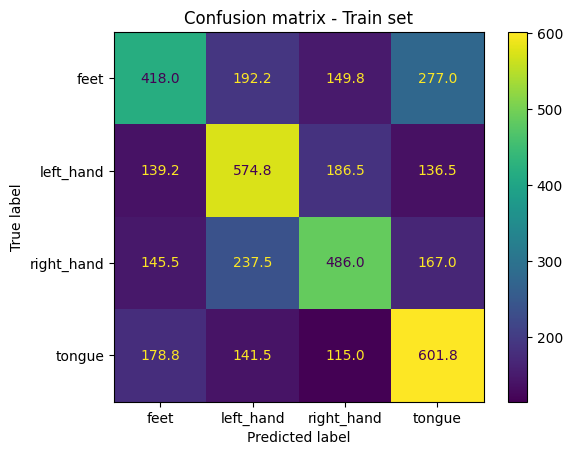

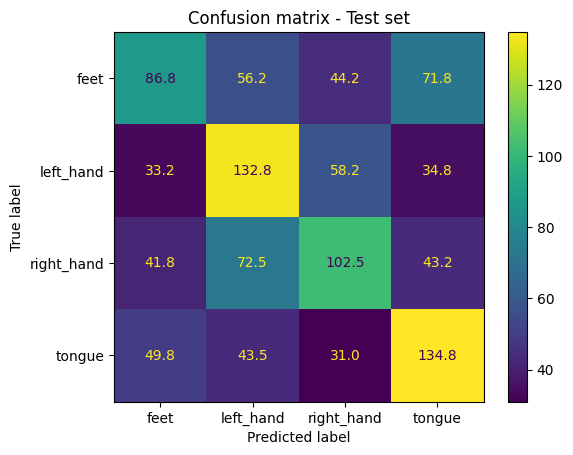

(array([[418.  , 192.25, 149.75, 277.  ],
        [139.25, 574.75, 186.5 , 136.5 ],
        [145.5 , 237.5 , 486.  , 167.  ],
        [178.75, 141.5 , 115.  , 601.75]]),
 array([[ 86.75,  56.25,  44.25,  71.75],
        [ 33.25, 132.75,  58.25,  34.75],
        [ 41.75,  72.5 , 102.5 ,  43.25],
        [ 49.75,  43.5 ,  31.  , 134.75]]))

In [51]:
mu.confusiong_avg(mods,X_train, y_train, X_test, y_test,plots=True)

## Graphs


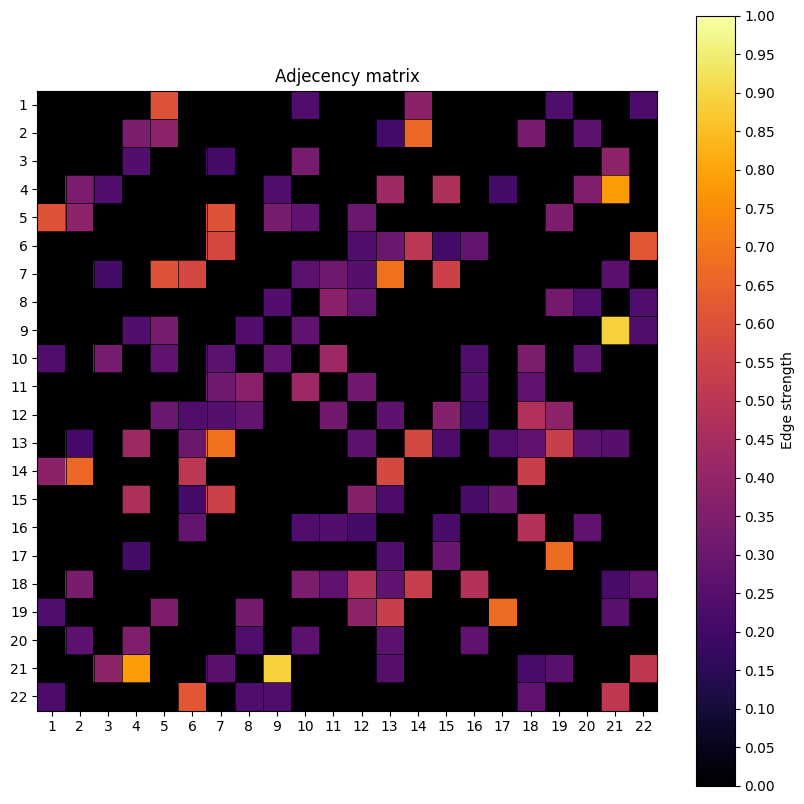

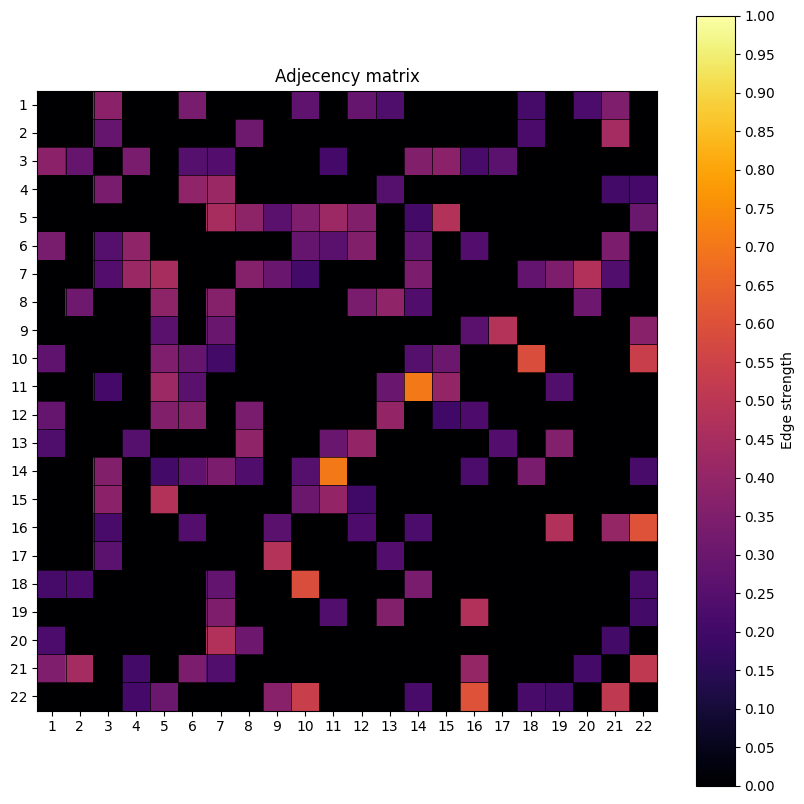

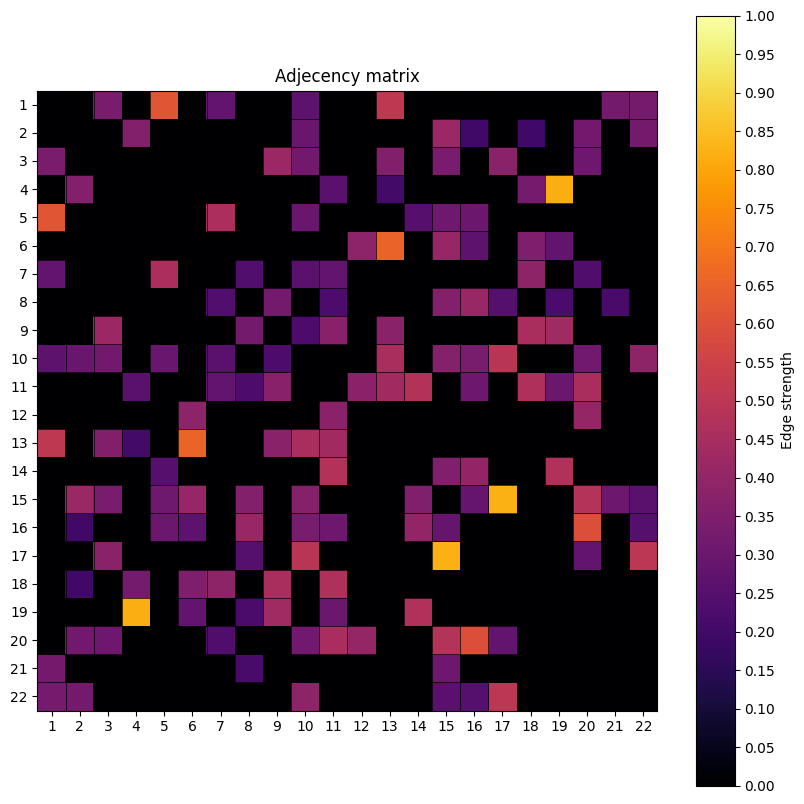

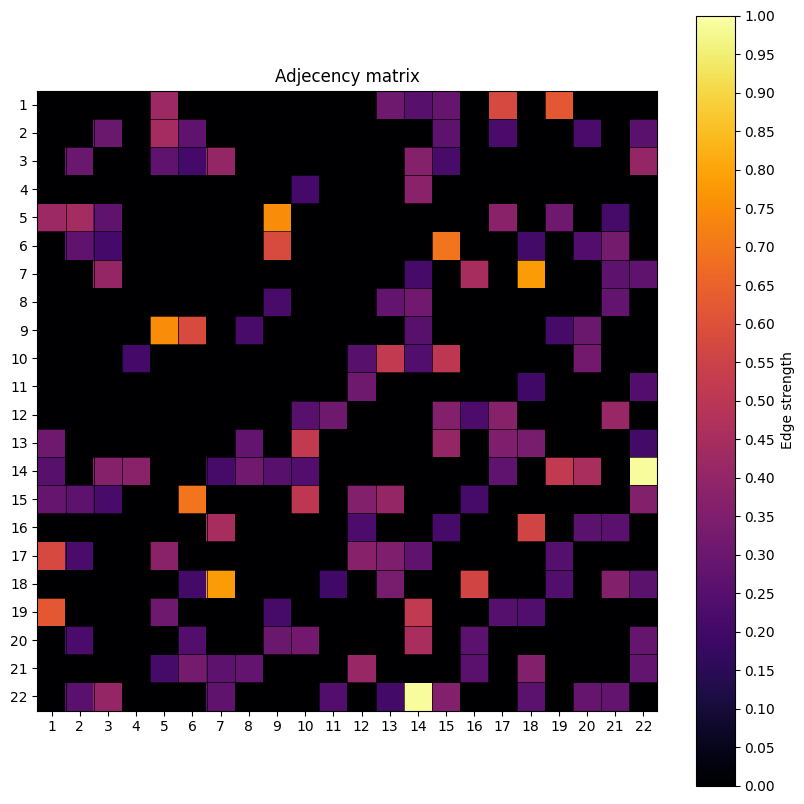

In [52]:
graphs=[]
adj_mats=[]
for i in range(modruns):
    adj_mats.append(mu.get_adj_mat(mods[i][0]))
    graphs.append(gu.make_graph(adj_mats[i]))
if plot:
    for adj in adj_mats:
        vu.visualize_adj_mat(adj)
#throw error if isomophic
for G1 in range(len(mods)):
    for G2 in range(G1+1,len(mods)):
        assert gu.check_not_isomorphism(graphs[G1],graphs[G2]), f"Graph G{G1} and G{G2} are isomophic"

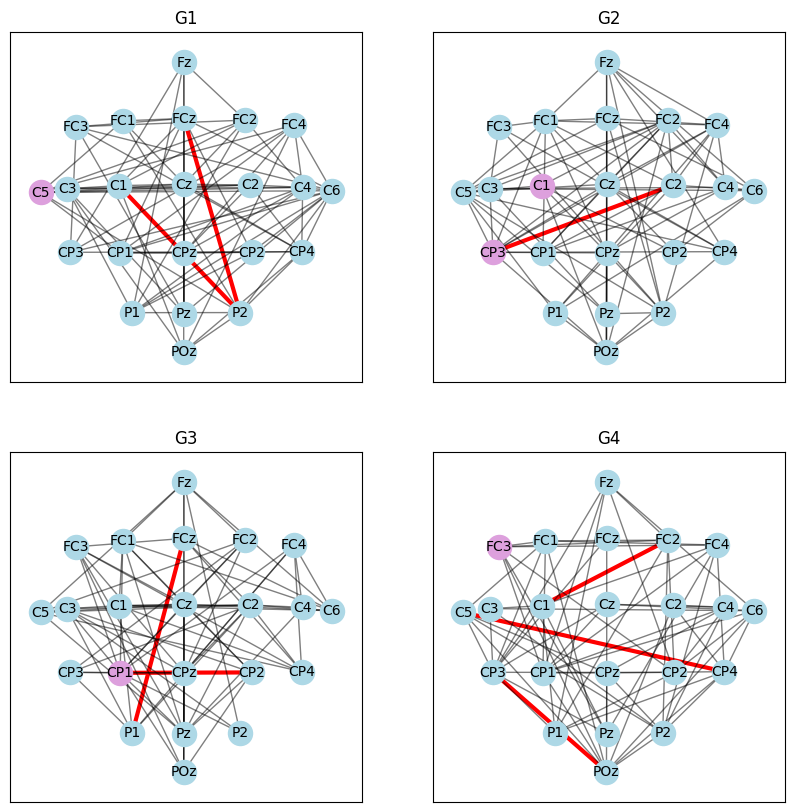

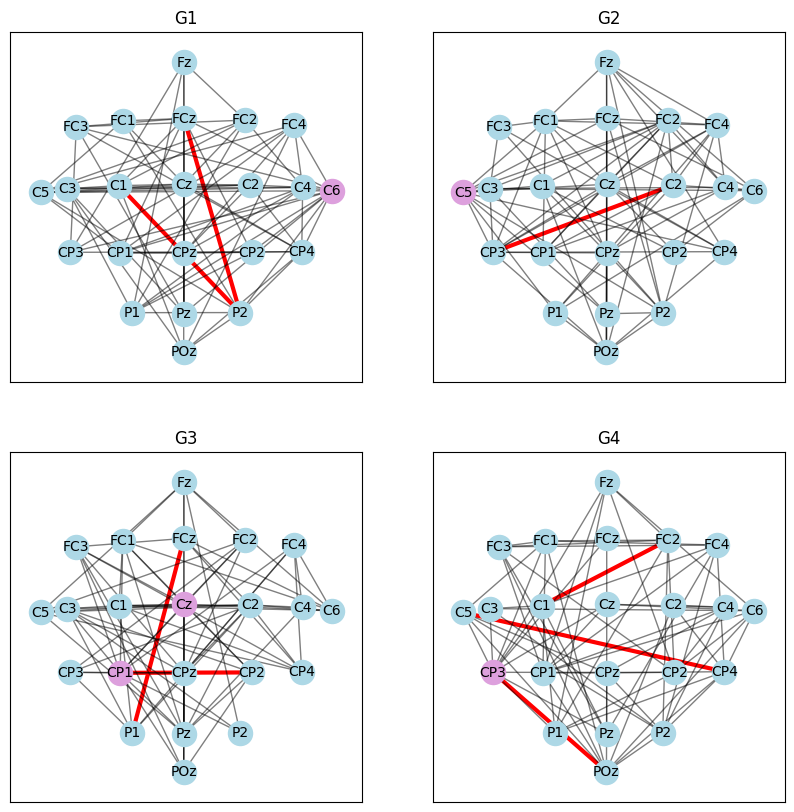

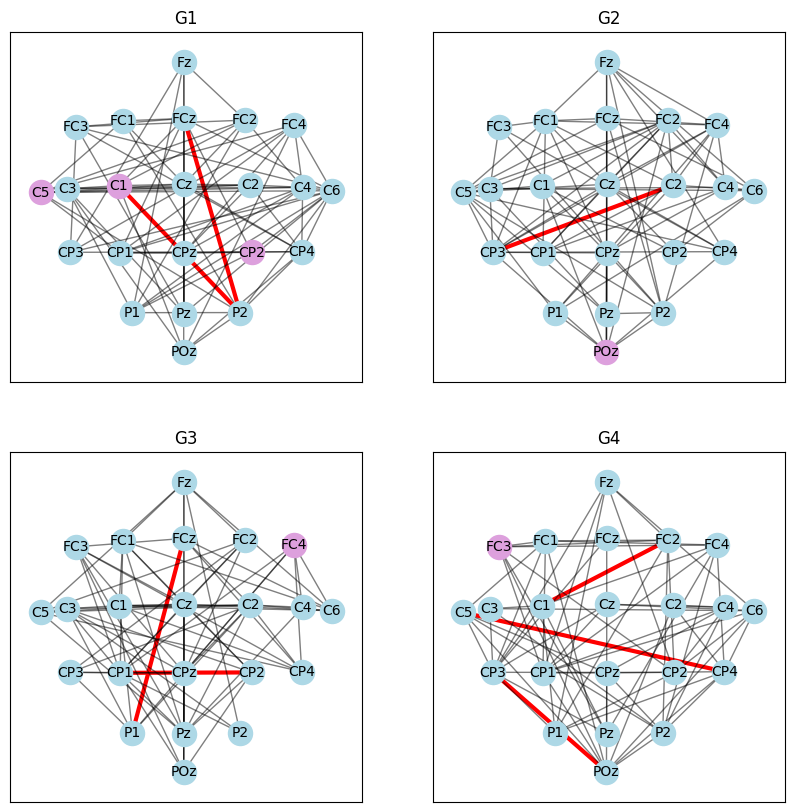

In [53]:
if plot:
    for i in param_list:
        bary_list = barycenters[i]
        vu.graph_plot(adj_mats,vu.graph_visual,2,2,bary_list)

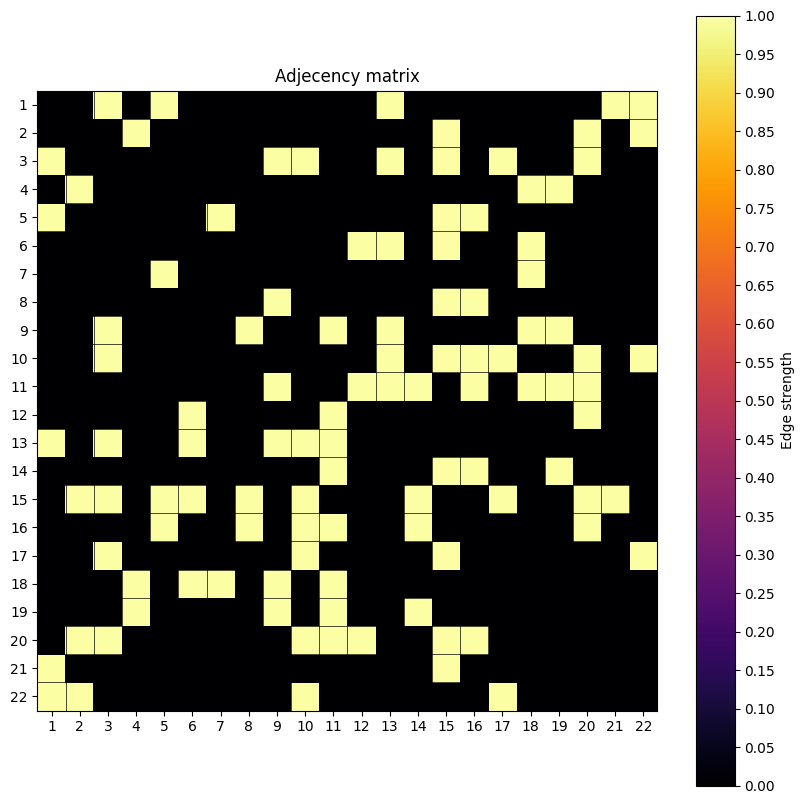

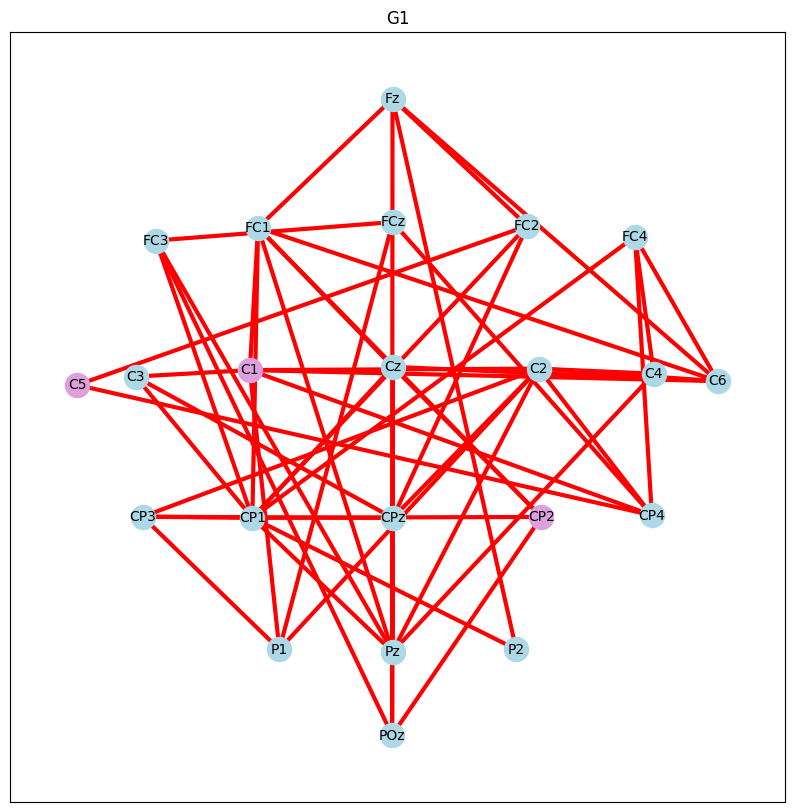

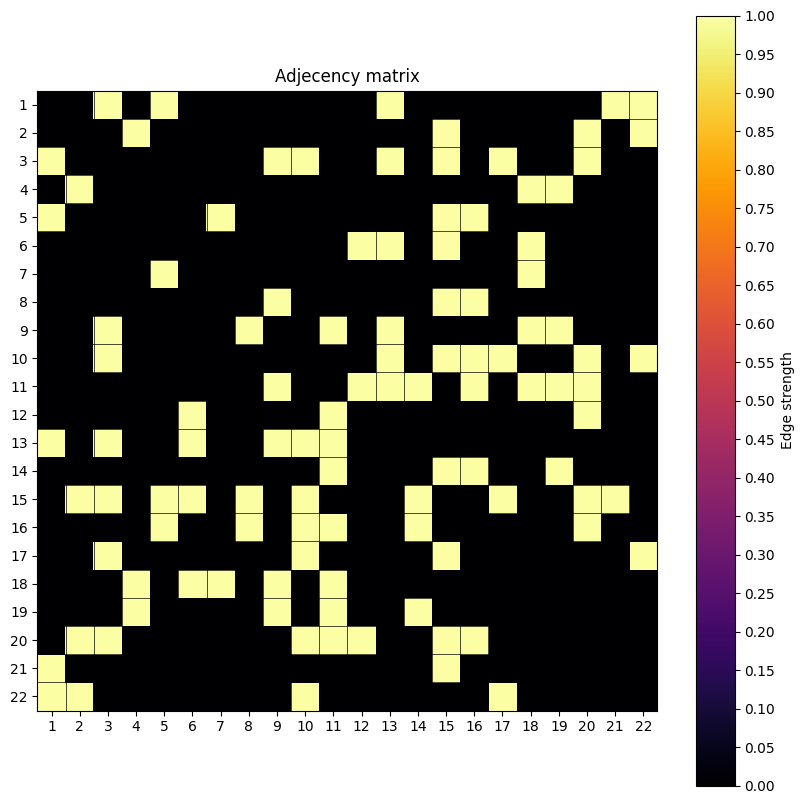

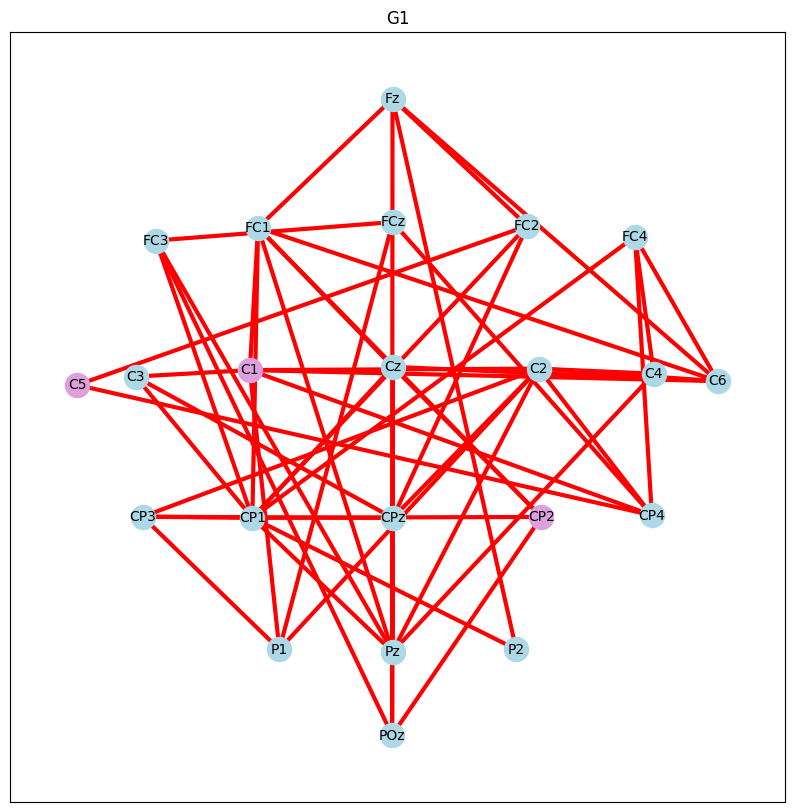

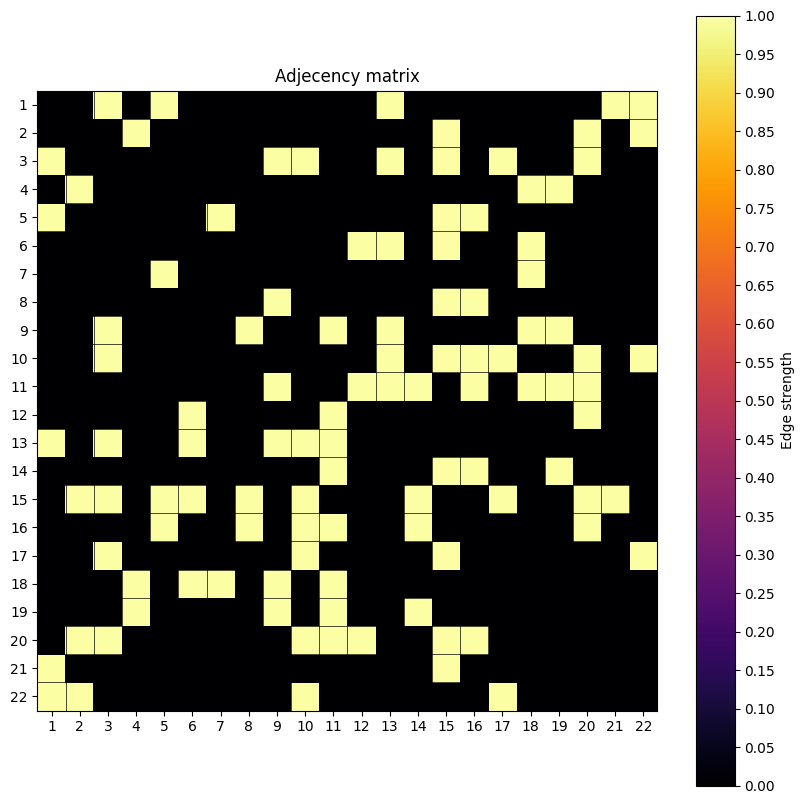

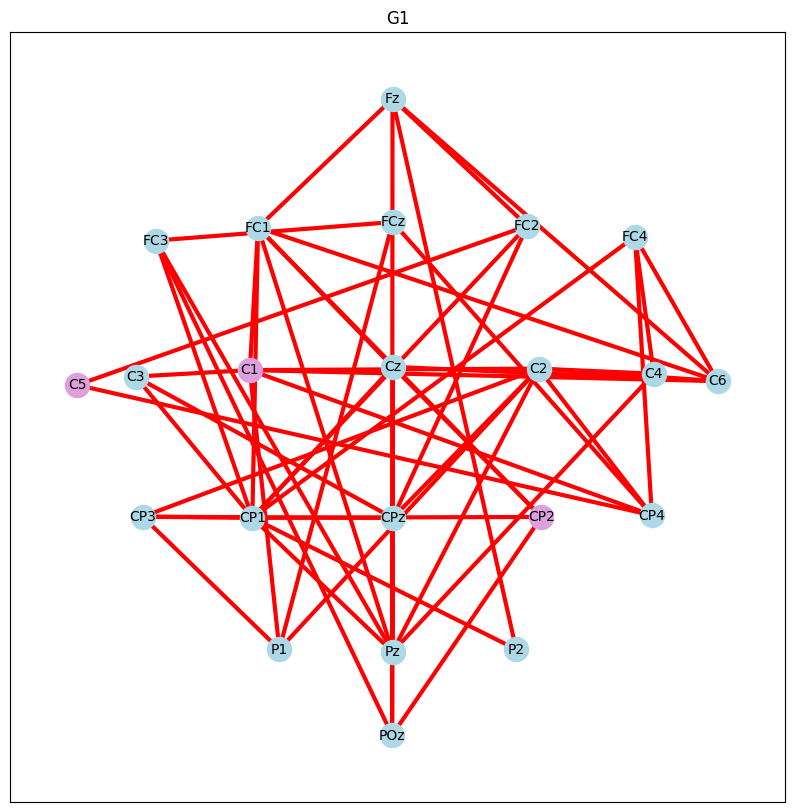

In [54]:
bi_g, bi_adj = gu.make_binary_graph(adj_mats[2],thresh=0.3)
if plot:
    for i in param_list:
        vu.visualize_adj_mat(bi_adj)
        vu.graph_plot([bi_adj],vu.graph_visual,1,1,bary_list)

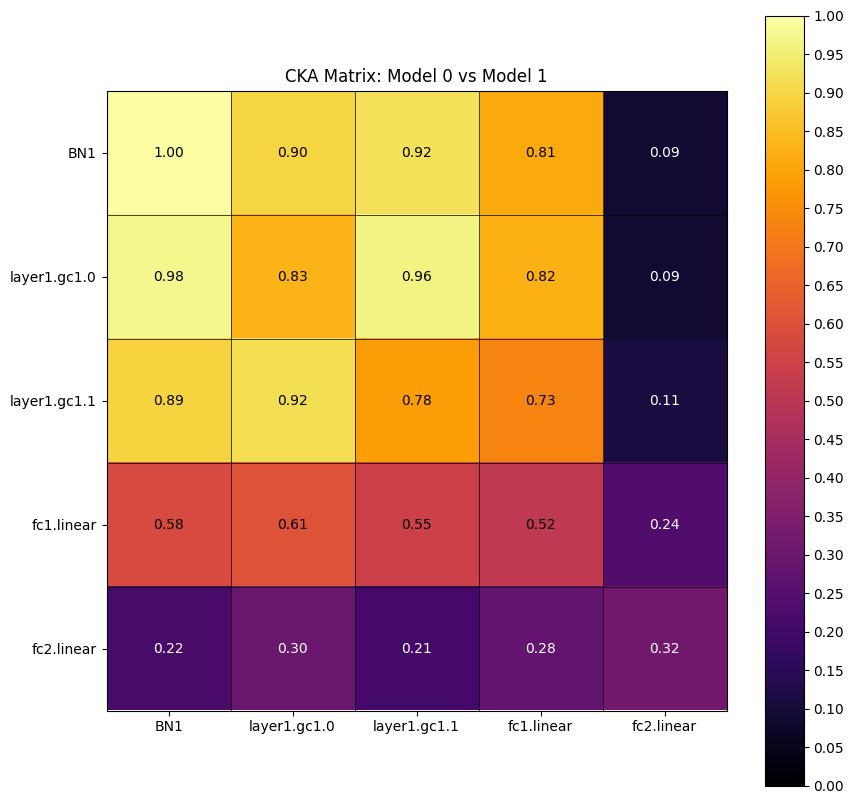

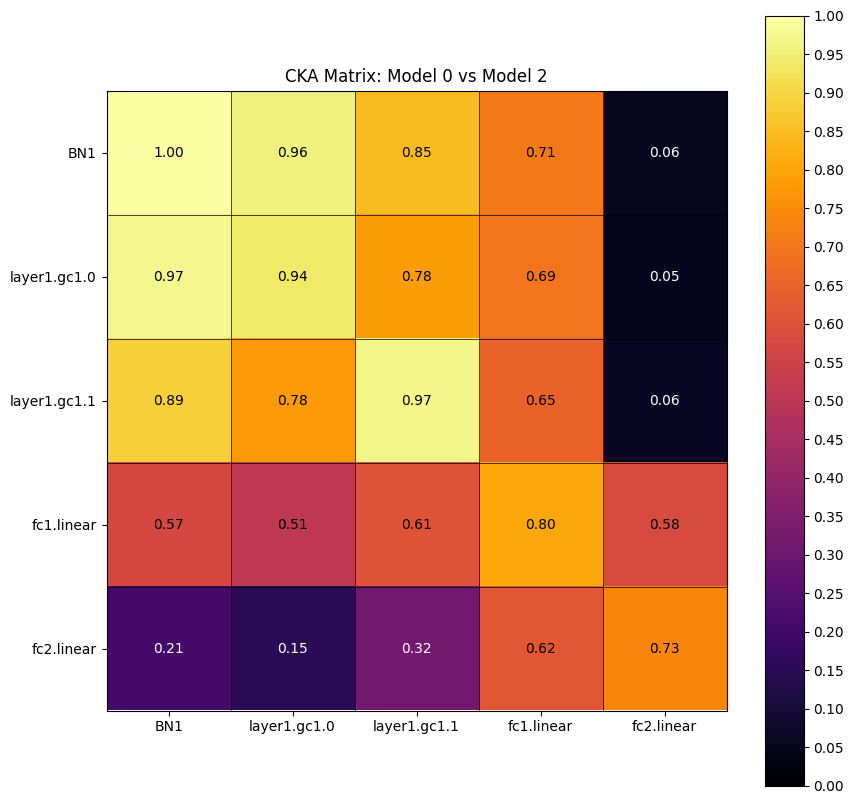

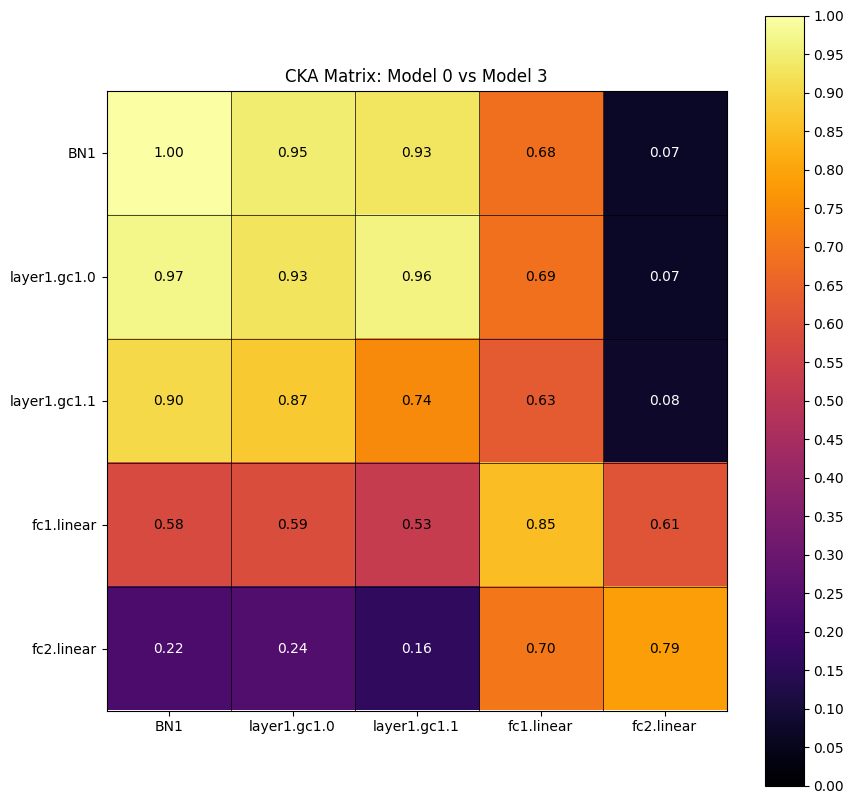

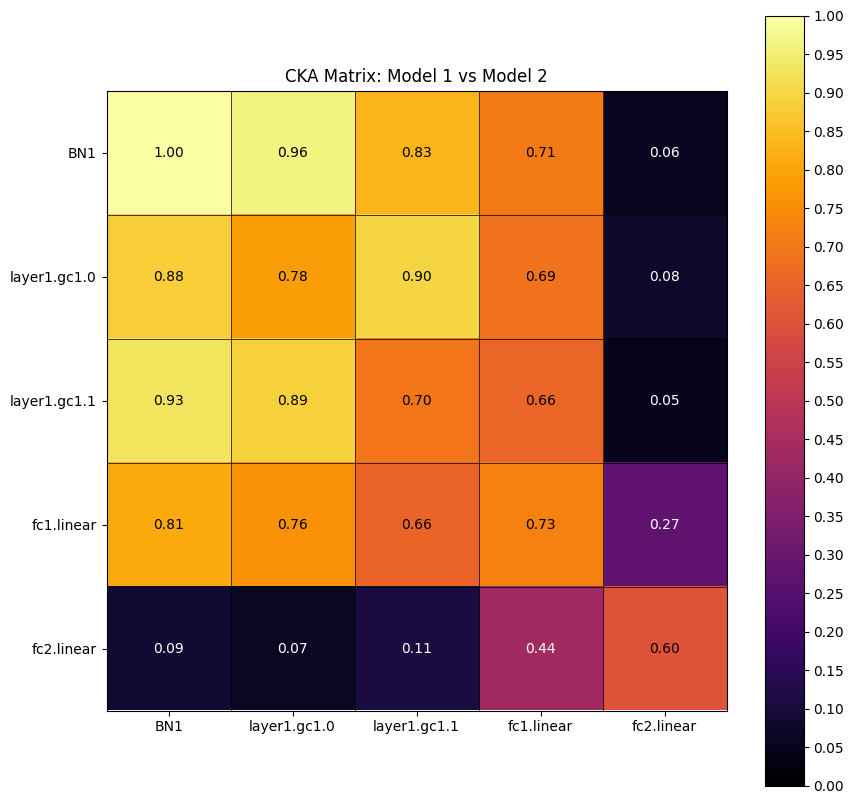

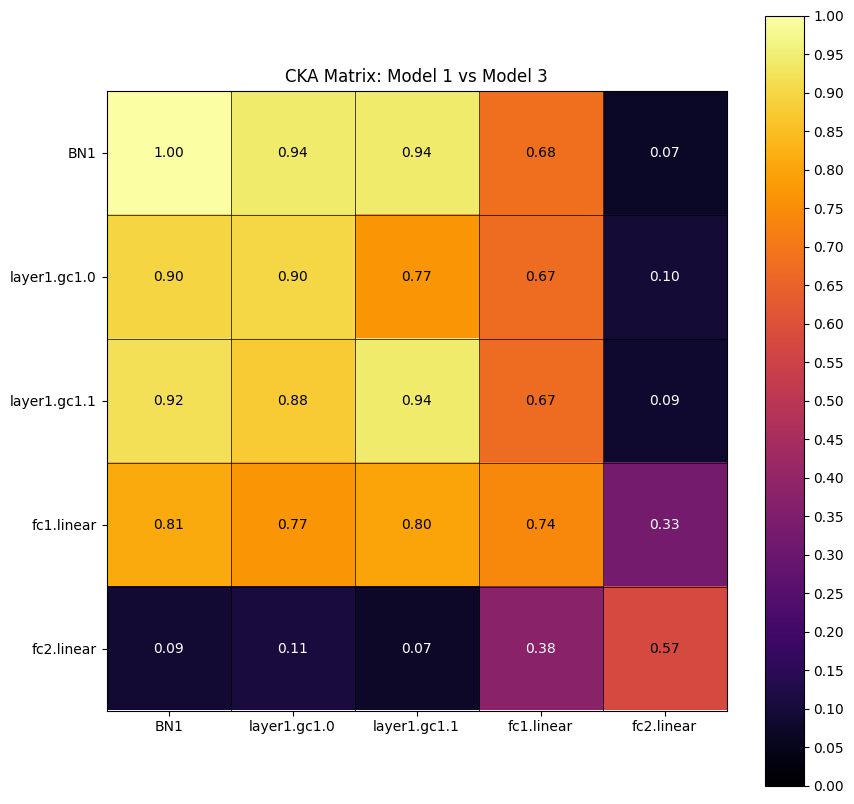

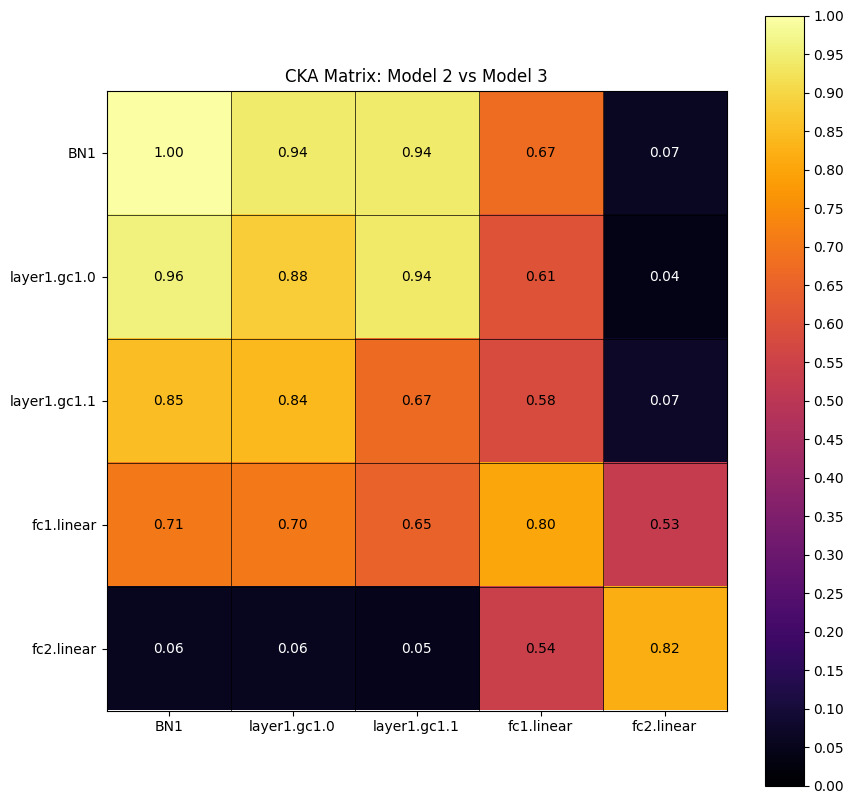

In [55]:
cka_all = []
for i in range(modruns-1):
    for j in range(i+1,modruns):
        calculator = CKACalculator(model1=mods[i][0], model2=mods[j][0], 
                                dataloader=train_loader,
                                layers_to_hook=(nn.Conv2d, nn.Linear,
                                     nn.AdaptiveAvgPool2d, GraphConvolution, nn.BatchNorm1d))
        cka_output = calculator.calculate_cka_matrix(train_dataset)
        #calculator.test_cka(10,train_dataset)
        cka_all.append(cka_output)
        if plot:
            vu.plot_matrix(f'CKA Matrix: Model {i} vs Model {j}'
                          ,cka_output.cpu().numpy(),calculator.module_names_X,
                           calculator.module_names_Y)

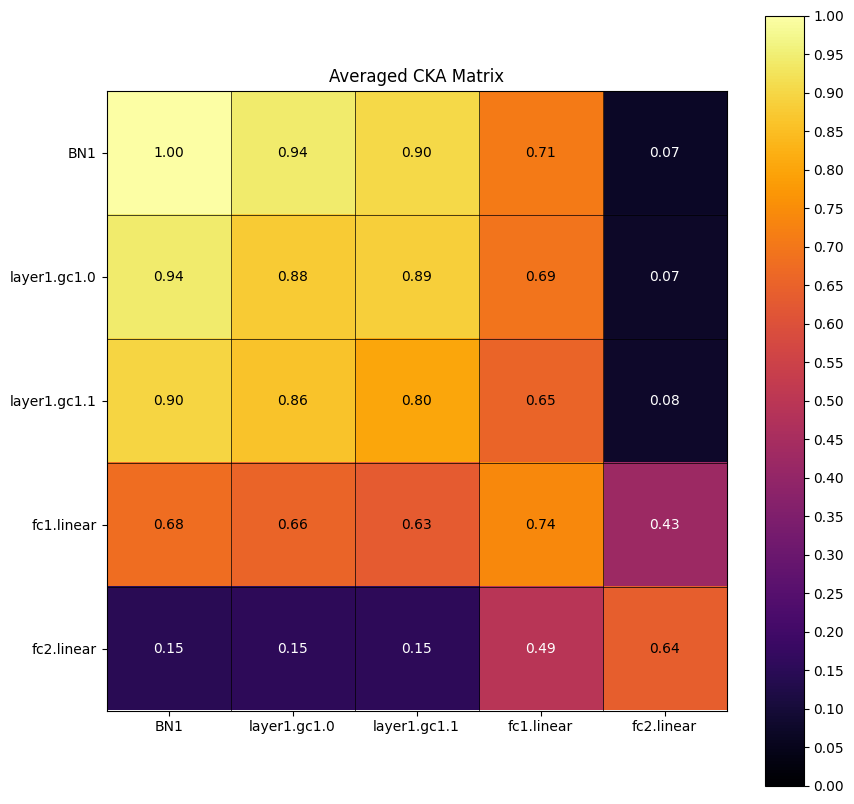

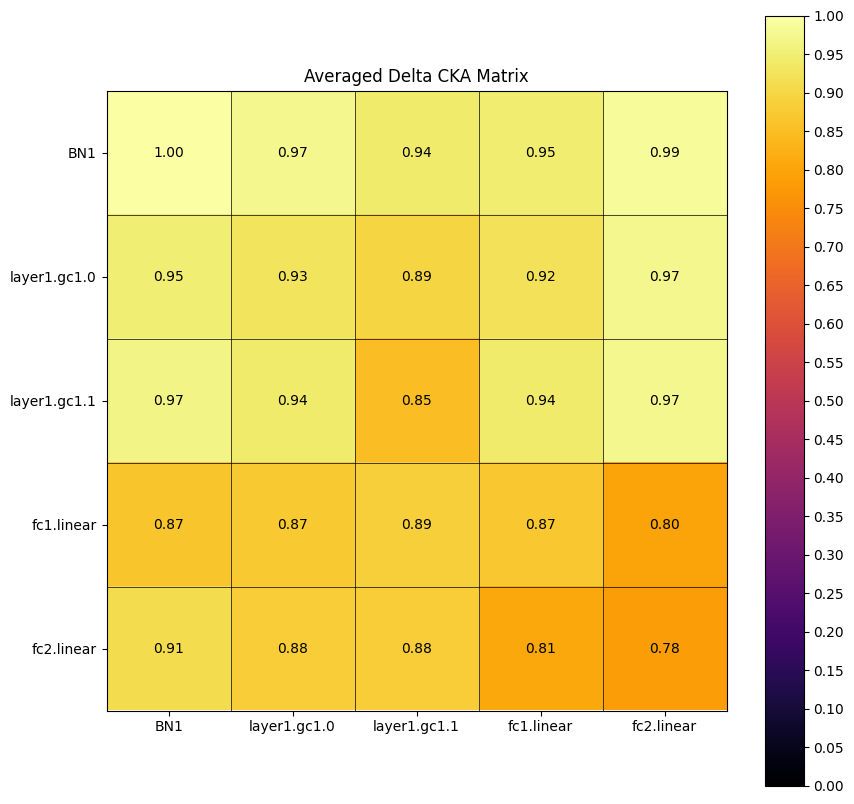

In [56]:
cka_stack = torch.stack(cka_all) 
average_cka_matrix = cka_stack.mean(dim=0)
delta_matrices = []

for i in range(len(cka_stack)):
    for j in range(i+1,len(cka_stack)):
        delta_matrices.append(torch.abs(cka_stack[i] - cka_stack[j])) 
        
delta_matrices = torch.stack(delta_matrices)  
average_delta_cka_matrix = 1- delta_matrices.mean(dim=0)  
if plot:
    vu.plot_matrix("Averaged CKA Matrix",average_cka_matrix.cpu().numpy(),calculator.module_names_X,calculator.module_names_Y)
    vu.plot_matrix("Averaged Delta CKA Matrix",average_delta_cka_matrix.cpu().numpy(),calculator.module_names_X,calculator.module_names_Y)

In [57]:
if has_val_set:

    for i  in range (len(mods)):
        filepath=f"{path}/Training_validation_loss{i}.npy"
        if not new_models:
            try: 
                with open(filepath, "rb") as f:
                    data = np.load(f)
            except:
                print(f"File with the data could not be found looking at address: {filepath}")
        else:
            with open(filepath, "wb") as f:
                np.save(f, mods[0][1])
                data = mods[0][1]
        plt.plot(data[0])
        plt.plot(data[1])
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend(["training loss","validation loss"])
        plt.title(f"Model{i} Training vs validation loss")
        plt.show()
    

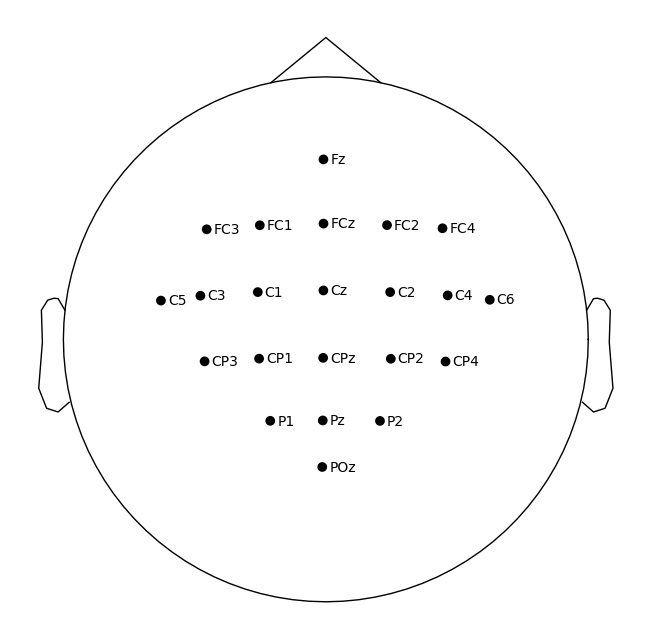

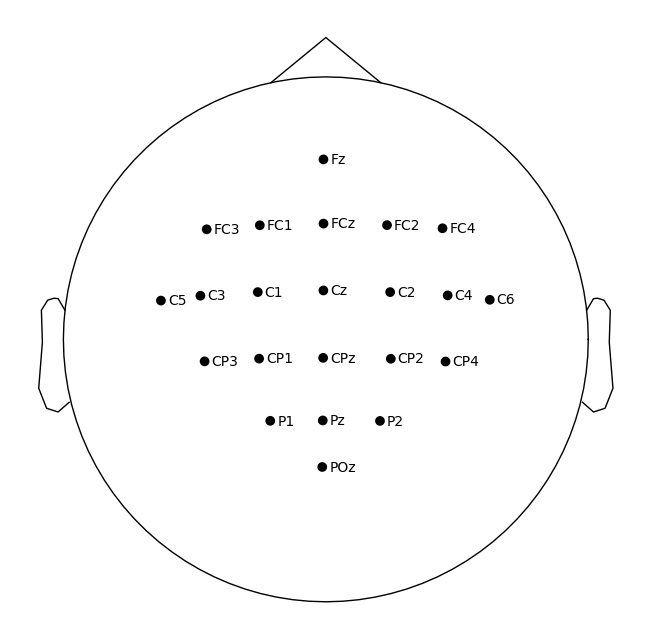

In [58]:
node_labels = pd.read_csv("node_names.tsv", sep="\t")
node_labels = list(node_labels['name'])

info = mne.create_info(ch_names=node_labels,sfreq=1000,ch_types='eeg')

n_channels = len(node_labels)
data = np.zeros((n_channels, 1000))

raw = mne.io.RawArray(data, info)

montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)

raw.plot_sensors(kind='topomap', show_names=True)